# RCA Case 2 - Uber


---
### Problem Statement :
---

Uber has received some complaints from their customers facing problems related to ride cancellations by the driver and non-availability of cars for a specific route in the city.

The uneven supply-demand gap for cabs from City to Airport and vice-versa is causing a bad effect on customer relationships as well as Uber is losing out on its revenue.

The aim of analysis is to identify the root cause of the problem (i.e. cancellation and non-availability of cars) and recommend ways to tackle the situation.

---

`Instructor Note:`
- Summarize and discuss the problem statement with the learners.

- Talk about how we came to know about the issue.

- Define ride cancellation rate = $\frac{No. of confirmed bookings}{No. of ride requests}$

- Categorise the ride cancellations into two groups -
  1. Intercity
  2. City to Airport (or vice-versa)

- Ask the learners to formulate possible hypotheses that we can test with or without the data given.

- Divide these hypotheses into Internal & External factors and validate them one by one.
---

First of all, irrespective of the data that we have, there are some questions that we need to ask as a Data/Product Analyst to get some clarity on the issue.

---

#### *Questions that we can ask :*

    Q. Is this thing happening for specific devices? (Android or iOS)

    Q. Has there been any major change/upgrade in the product?

    Q. Is this increase in cancellation rate gradual or sudden?

    Q. Have we checked for any issues on the driver app?

    Q. Are we receiving any major complaints or bug reports?

    Q. Is the change observed across several regions specifically or is it uniform?

    Q. Are we seeing a high cancellation rate for driver’s belonging to a specific age group?

    Q. Any pattern in ride cancellations in terms of the vehicle category? (Auto, Mini or Sedan)

    Q. Has there been any major holiday in the past week?

    Q. Have we done any recent experiments related to the platform?

    Q. Has there been any recent strike or protest by the drivers?

    Q. Has Uber been involved in any controversy lately?

    Q. Are we currently facing any connectivity related issues throughout the region?

    Q. Do we have any reports of frequent app crashes or something like that?

    Q. Is there any change detected in the usual user behavior over the last week?

    Q. Is it possible that the drivers might be using some other ride sharing platforms as well?

---

#### *Things that we'll be looking at :*

    - Frequency of booking requests getting cancelled each hour.

    - Pickup & Destination of the cancelled booking requests.

    - Days of week in which the cancellation rate is maximum.

    - Time of day during which the cancellation rate is at peak.

    - Time of day when the demand is highest and supply is low.

    - Time of day when the cabs are available but demand is low.

---

In [10]:
# Importing required libraries -

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import warnings
warnings.simplefilter('ignore')

sns.set_style('whitegrid')

In [12]:
# Loading the dataset -

df = pd.read_csv('RCA uber-data - uber-data.csv', parse_dates=[4,5], dayfirst=True, na_values="NA")
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


In [13]:
# Shape of the dataset -

print("No. of rows: {}".format(df.shape[0]))
print("No. of cols: {}".format(df.shape[1]))

No. of rows: 6745
No. of cols: 6


In [14]:
# Checking the data type -

df.info(null_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Request id         int64         
 1   Pickup point       object        
 2   Driver id          float64       
 3   Status             object        
 4   Request timestamp  datetime64[ns]
 5   Drop timestamp     datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 316.3+ KB


In [15]:
# Checking for null values -

df.isnull().sum() / len(df) * 100

Request id            0.000000
Pickup point          0.000000
Driver id            39.288362
Status                0.000000
Request timestamp     0.000000
Drop timestamp       58.028169
dtype: float64

In [16]:
# Checking for duplicate rows -

print("No. of duplicate rows: ", df.duplicated().sum())

No. of duplicate rows:  0


*Extracting new features from the existing ones -*

In [17]:
# Extract hour from the Request timestamp -

df["RequestHour"] = df["Request timestamp"].dt.hour

In [18]:
# Separate 5 different timeslots from the Hour - Dawn, Early Morning, Noon, Late Evening, Night -

df["TimeSlot"] = df["RequestHour"].apply(lambda x: "Dawn" if x<=4 else ("Early Morning"
                                                                        if x<=9 else ("Noon"
                                                                                      if x<=16 else ("Late Evening"
                                                                                                     if x<=21 else "Night"))))

In [19]:
# Distinguish the Supply-Demand Gap by a new variable Cab Availability where Supply is when Trip is Completed, all else is Demand -

df["Cab Availability"] = df["Status"].apply(lambda x: "Available" if x=="Trip Completed" else "Not Available")

In [20]:
df.sample(5)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,RequestHour,TimeSlot,Cab Availability
2863,2986,City,9.0,Cancelled,2016-07-13 07:04:48,NaT,7,Early Morning,Not Available
982,373,Airport,102.0,Trip Completed,2016-07-11 08:09:00,2016-07-11 09:16:00,8,Early Morning,Available
5483,3797,Airport,NaN,No Cars Available,2016-07-13 20:56:07,NaT,20,Late Evening,Not Available
5228,3164,City,NaN,No Cars Available,2016-07-13 09:05:28,NaT,9,Early Morning,Not Available
6681,6611,Airport,NaN,No Cars Available,2016-07-15 21:47:07,NaT,21,Late Evening,Not Available


In [21]:
df['Cab Availability'].value_counts(normalize=True)*100

Not Available    58.028169
Available        41.971831
Name: Cab Availability, dtype: float64

**Q. What is the Frequency of Requests that get Canceled or show ‘No Cars Available’ in each hour?**

Text(0.5, 1.0, 'Frequency of Requests by Hour')

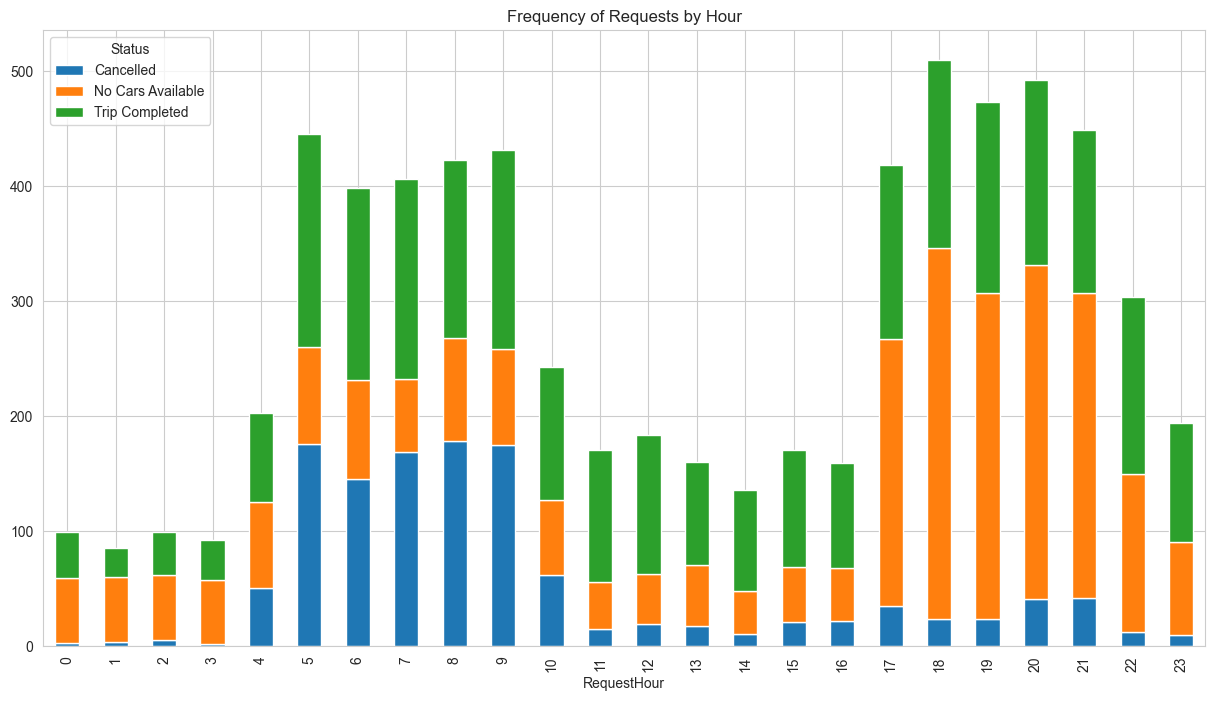

In [22]:
# Frequency of Requests by Hour -

df.groupby(['RequestHour','Status']).size().unstack().plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Frequency of Requests by Hour')

Text(0, 0.5, '')

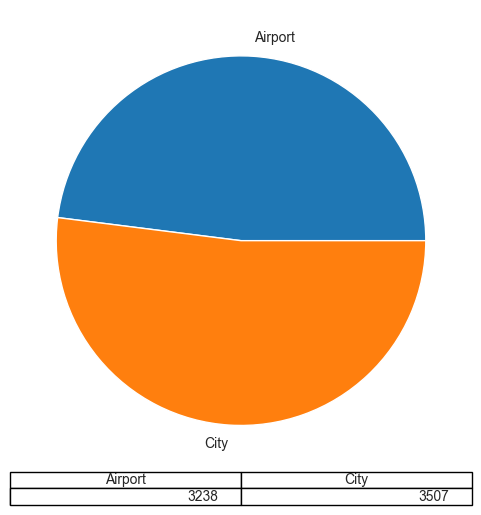

In [23]:
# Types of Requests (city-airport or airport-city) -

df.groupby(['Pickup point']).size().plot(kind="pie", stacked=True, figsize=(6, 6), table=True)
plt.ylabel("")

Text(0, 0.5, '')

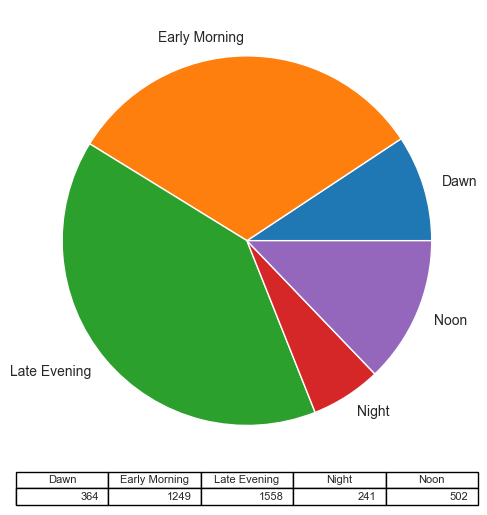

In [24]:
# Distribution of Time Slots -

df[(df["Cab Availability"]=="Not Available")].groupby(['TimeSlot']).size().plot(kind="pie", stacked=True, figsize=(6, 6), table=True)
plt.ylabel("")

**Observation:** <br>
*Late Evenings* and *Early Mornings* are not recommended for Airport-City transport or vice versa.

**Q. Plot the Demand-Supply Gap from Airport to City.**

Text(0.5, 1.0, 'Demand-Supply Gap from Airport to City')

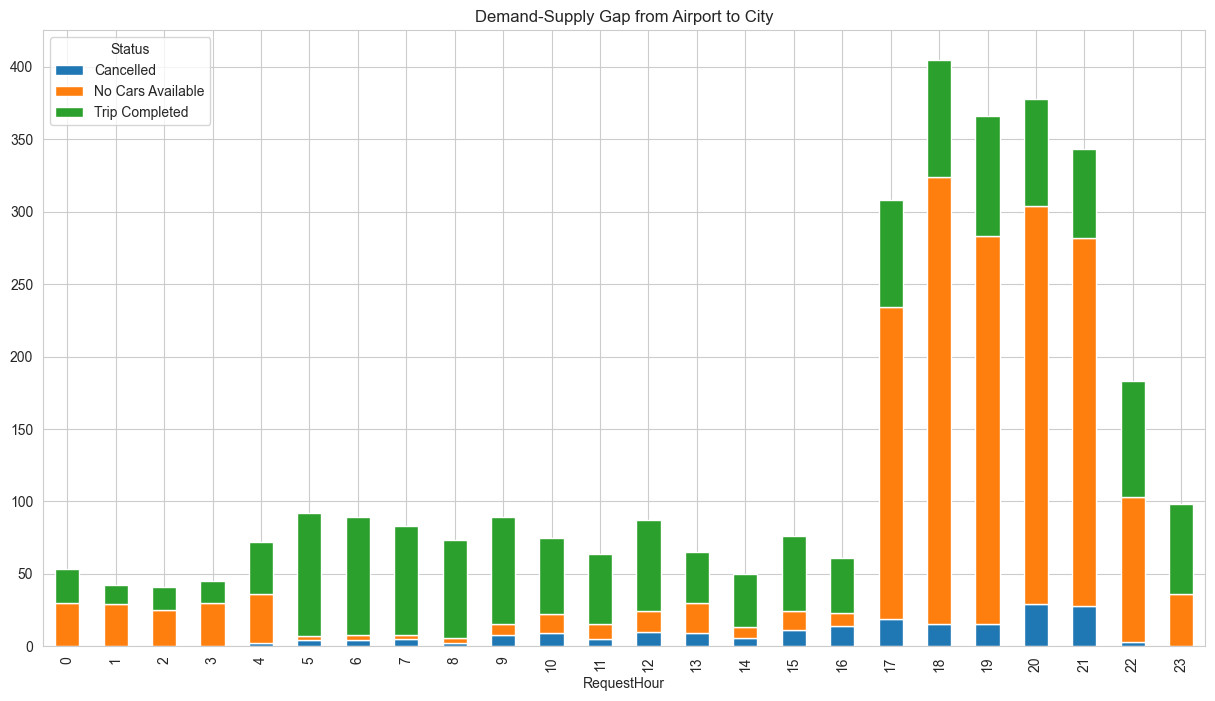

In [25]:
# Demand-Supply Gap from Airport to City -

df[(df['Pickup point']=="Airport")].groupby(['RequestHour','Status']).size().unstack().plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Demand-Supply Gap from Airport to City')

**Observation:**
- *There is very high demand for cabs from Airport to City between 5:00 PM – 9:00 PM*
- *But the supply is very less due primarily due to ‘No Cabs Available'*

**Q. Plot the Demand-Supply Gap from City to Airport.**

Text(0.5, 1.0, 'Demand-Supply Gap from City to Airport')

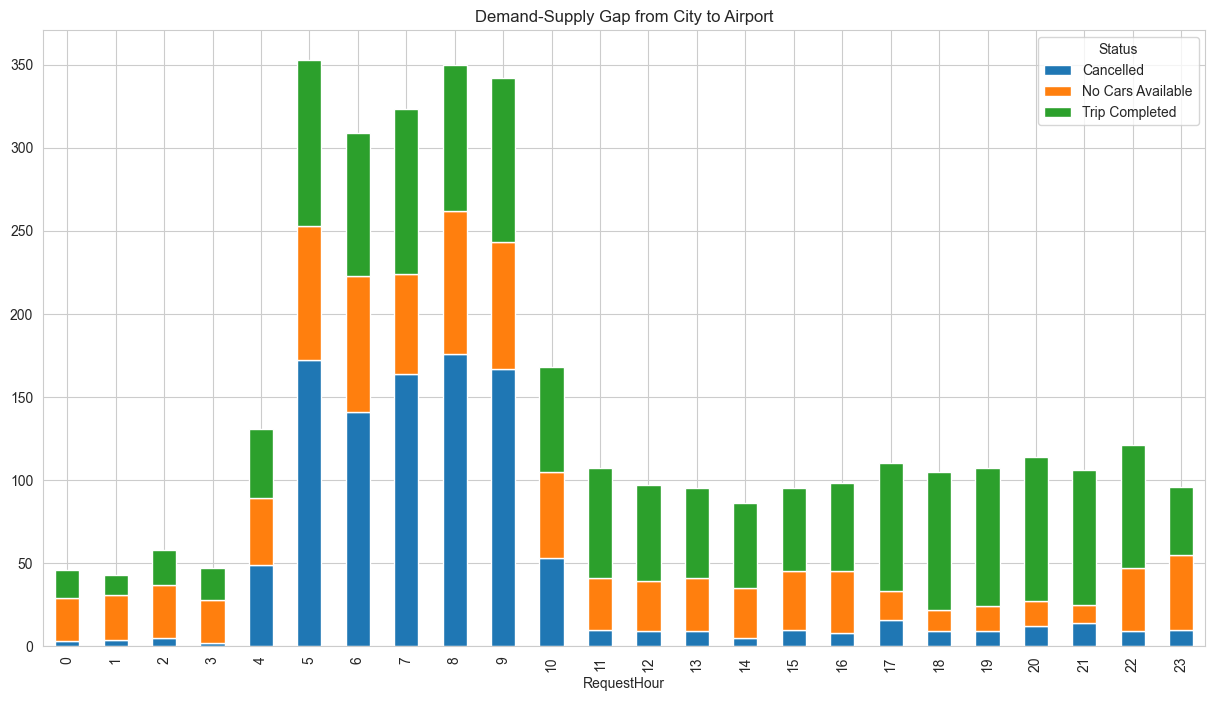

In [26]:
# Demand-Supply Gap from City to Airport -

df[(df['Pickup point']=="City")].groupby(['RequestHour','Status']).size().unstack().plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Demand-Supply Gap from City to Airport')

**Observation:**
- *There is very high demand for cabs from City to Airport between 5:00 AM – 9:00 AM*
- *But the supply is very less primarily due to Ride Cancellations*

**Q. What are the Time Slots where the highest gap exists?**

Text(0.5, 1.0, 'Time slots where highest gap exists')

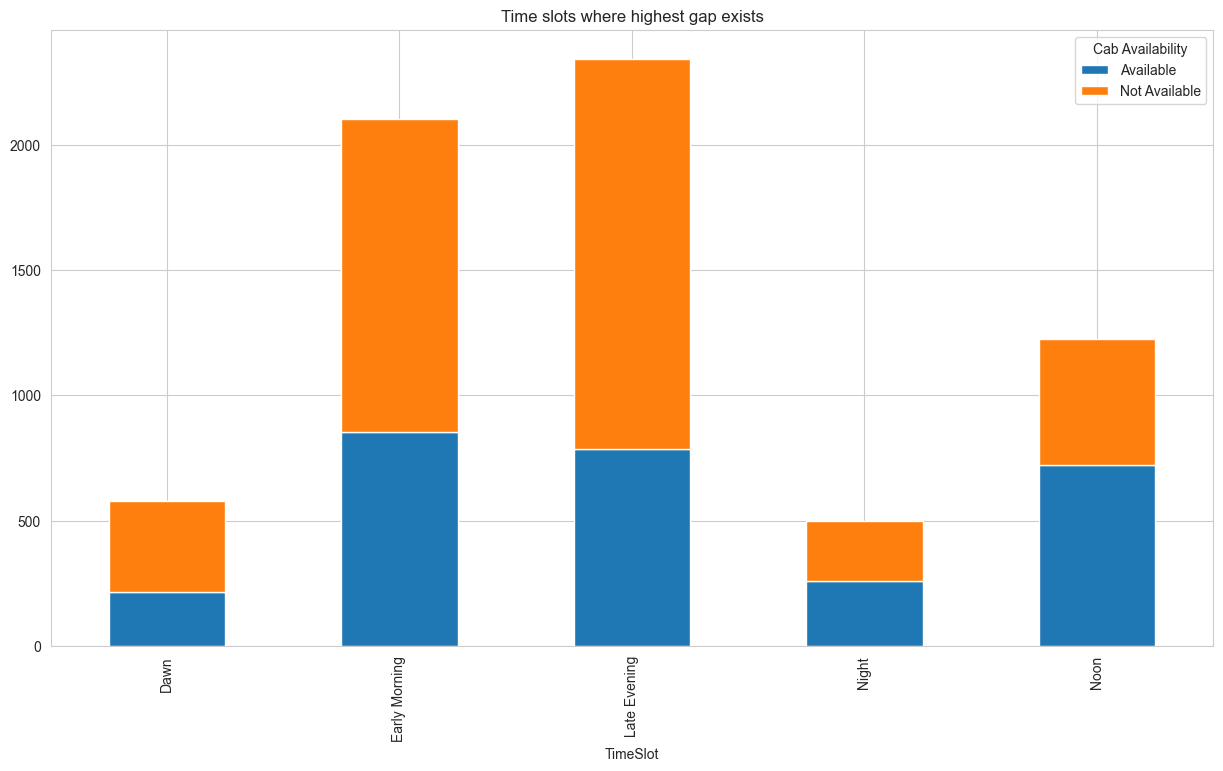

In [27]:
# Time slots where highest gap exists -

df.groupby(['TimeSlot','Cab Availability']).size().unstack().plot(kind='bar', stacked=True,figsize=(15, 8))
plt.title('Time slots where highest gap exists')

**Observation:** </br>
- *Among the assumed time slots, we can see that the Late
Evening and Early Morning time slots has got the
highest gap.*
- *This means that during evening & morning hours the probability of
getting a cab is very less.*

Text(0, 0.5, '')

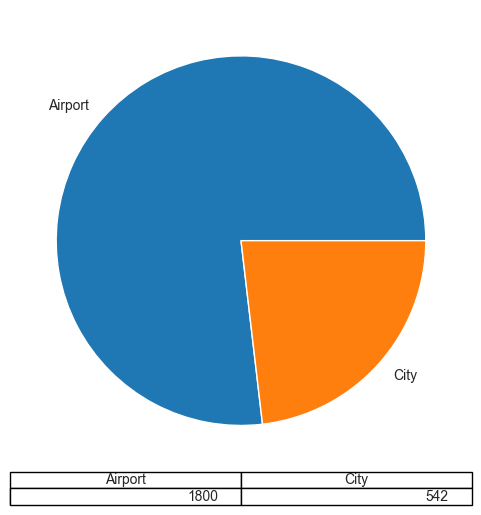

In [28]:
#  Types of Requests (city-airport or airport-city) for which the gap is the most severe in the identified time slots -

df[df["TimeSlot"]=="Late Evening"].groupby(['Pickup point']).size().plot(kind="pie",stacked=True,figsize=(6, 6), table=True)
plt.ylabel("")

Text(0, 0.5, '')

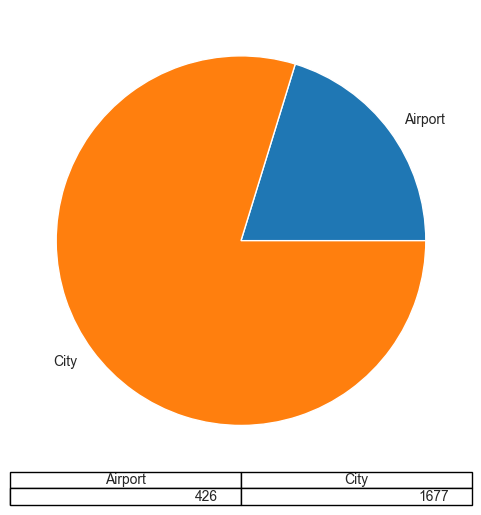

In [29]:
#  Types of Requests (city-airport or airport-city) for which the gap is the most severe in the identified time slots -

df[df["TimeSlot"]=="Early Morning"].groupby(['Pickup point']).size().plot(kind="pie",stacked=True,figsize=(6, 6), table=True)
plt.ylabel("")

---
### Reason for Supply-Demand gap -
---

* In the Supply-Demand graph from Airport to City, between 5:00 PM to 9:00 PM there is very high demand for cabs because the supply is very low due to ‘No Cars Available’.

* The ‘No Cars Available’ is due to the fact that in the previous hours fewer people travelled from City – Airport and so fewer cars are available in near Airport.

* Likewise, in Supply-Demand graph from City – Airport, between 5:00 AM to 9:00 AM, there is very high demand for cabs because the supply is very low due to Ride Cancellations.

* This is because there were fewer trips to Airport that completed in the previous hours, so now the cabs have to come from a long distance (City) to pickup the passenger and then they have to wait for the passenger’s arrival, so the drivers cancel the trip.

---
### Recommendations -
---

* Awarding incentive for waiting time will encourage the drivers to wait at Airport.

* Drivers could be compensated for taking the night shifts hence covering the 00:00 – 5:00 time slot.

* Seeing this analysis trends, few cabs could be placed in Airports proactively.

* Drivers to be rewarded for the Airport rides making up for the loss in time.

* The cab discovery range to be increased for Airport location, so that the search for cabs would be on a wider range.